<a href="https://colab.research.google.com/github/Yang-star-source/Latent_Diffusion_From_Scratch/blob/main/Get_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from huggingface_hub import hf_hub_download
import os

repo_id = "ziyang06315/cats_images_dataset"
DATASET_PATH = "/content/cats"
os.makedirs(DATASET_PATH,exist_ok=True)
cats_images_dataset = hf_hub_download(repo_id=repo_id,
                                      filename="cat.zip",
                                      repo_type="dataset")
!unzip -q {cats_images_dataset} -d {DATASET_PATH}


In [ ]:
# Install a version of transformers that works with Florence-2
!pip install transformers==4.41.2 timm einops pillow

# Load Florence-2
This model can do captioning , object detection , image segmentation and reading text in images

**Prompt :**

- **Captioning** : MORE_DETAILED_CAPTION
- **Object Detection** : CAPTION_TO_PHRASE_GROUNDING
- **Segmentation** : REFERRING_EXPRESSION_SEGMENTATION
- **OCR** : OCR or OCR_WITH_REGION

Documentation : https://huggingface.co/microsoft/Florence-2-large

Tutorial : https://huggingface.co/microsoft/Florence-2-large/blob/main/sample_inference.ipynb

# Gemini Summarise
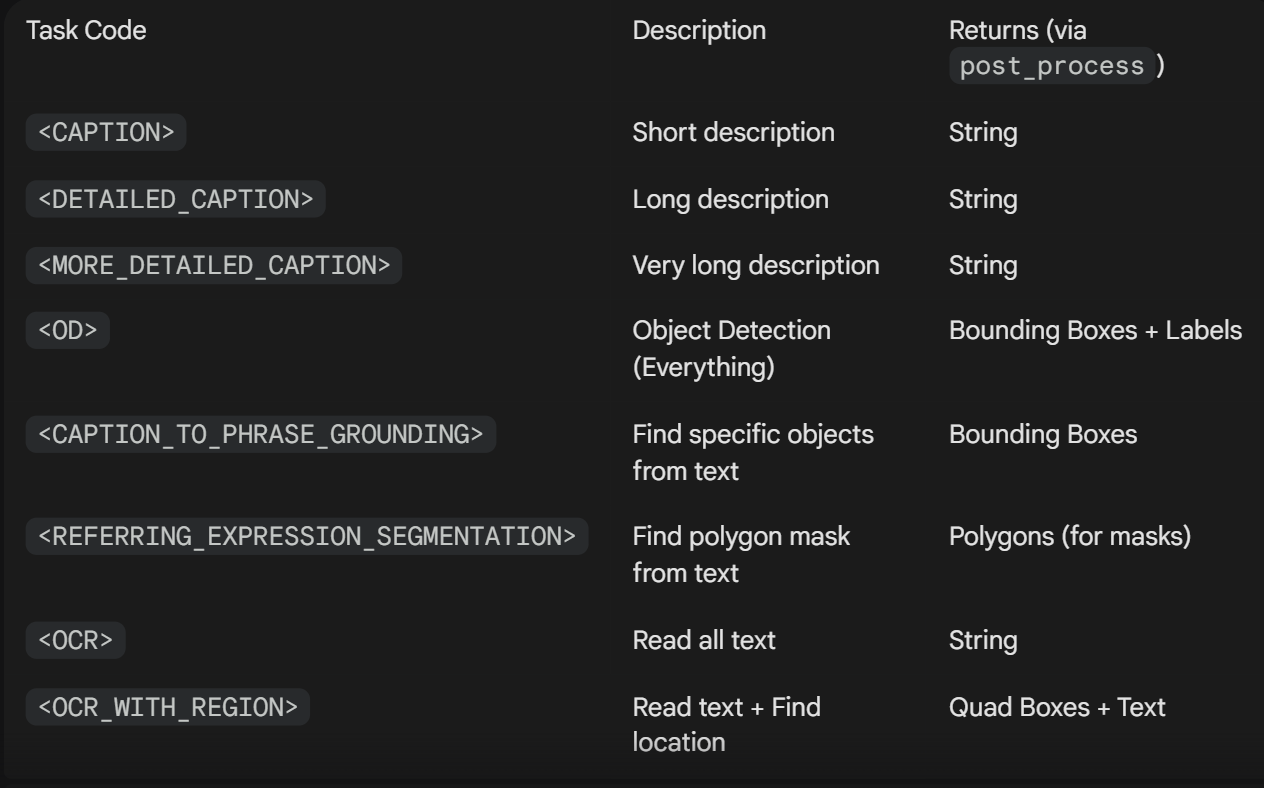

In [ ]:
import os
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM

# Install flash_attn which is a dependency for the model
!pip install flash_attn

IMAGE_FOLDER = "/content/cats"
MODEL_ID = "microsoft/Florence-2-large"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    trust_remote_code=True
).to(DEVICE).eval()

processor = AutoProcessor.from_pretrained(
    MODEL_ID,
    trust_remote_code=True
)

def generate_caption(image_path):
    image = Image.open(image_path).convert("RGB")

    # Prompt for detailed description
    prompt = "<MORE_DETAILED_CAPTION>"

    # inputs is a Dict {input_ids: ... , pixel_values: ...}
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        # generated_ids is list of numbers of the ID of words
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )

    # Output example : "<s>A large brown cat.</s>"" , <s></s> is special token
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    # Can do a lot of task depends on prompt
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer[prompt]



files = [f for f in os.listdir(IMAGE_FOLDER) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for idx, filename in enumerate(files):
    img_path = os.path.join(IMAGE_FOLDER, filename)
    txt_path = os.path.join(IMAGE_FOLDER, os.path.splitext(filename)[0] + ".txt")

    # Skip if already exists
    if os.path.exists(txt_path):
        continue

    caption = generate_caption(img_path)
    if caption:
        with open(txt_path, "w") as f:
            f.write(caption)
        print(f"[{idx+1}/{len(files)}] Captioned {filename}")

In [ ]:
import shutil
from google.colab import files

SAVE_PATH = "/content/drive/MyDrive/captions"
shutil.make_archive(SAVE_PATH, 'zip', '/content/cats')
